In [50]:
import cv2
import numpy as np
import os
from gtts import gTTS
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl
import playsound

from tensorflow.keras.layers import Input

from src.yolo3.model import *
from src.yolo3.detect import *

from src.utils.image import *
from src.utils.datagen import *
from src.utils.fixes import *
import time
import serial

fix_tf_gpu()

In [51]:
## **Helper functions**

def prepare_model(approach):
    '''
    Prepare the YOLO model
    '''
    global input_shape, class_names, anchor_boxes, num_classes, num_anchors, model

    # shape (height, width) of the imput image
    input_shape = (416, 416)

    # class names
    if approach == 1: #헬맷, 조끼, 워커
        class_names = ['H', 'V', 'W']

    elif approach == 2: # 워커, 헬맷 쓴 워커, 조끼 입은 워커, 둘다 입은 워커
        class_names  = ['W','WH','WV','WHV']

    elif approach == 3: #워커인지 아닌지
        class_names  = ['W']

    else:
        raise NotImplementedError('Approach should be 1, 2, or 3')

    # anchor boxes
    if approach == 1:
        anchor_boxes = np.array(
            [
            np.array([[ 76,  59], [ 84, 136], [188, 225]]) /32, # output-1 anchor boxes
            np.array([[ 25,  15], [ 46,  29], [ 27,  56]]) /16, # output-2 anchor boxes
            np.array([[ 5,    3], [ 10,   8], [ 12,  26]]) /8   # output-3 anchor boxes
            ],
            dtype='float64'
        )
    else:
        anchor_boxes = np.array(
            [
            np.array([[ 73, 158], [128, 209], [224, 246]]) /32, # output-1 anchor boxes
            np.array([[ 32,  50], [ 40, 104], [ 76,  73]]) /16, # output-2 anchor boxes
            np.array([[ 6,   11], [ 11,  23], [ 19,  36]]) /8   # output-3 anchor boxes
            ],
            dtype='float64'
        )

    # number of classes and number of anchors
    num_classes = len(class_names)
    num_anchors = anchor_boxes.shape[0] * anchor_boxes.shape[1]

    # input and output
    input_tensor = Input( shape=(input_shape[0], input_shape[1], 3) ) # input
    num_out_filters = ( num_anchors//3 ) * ( 5 + num_classes )        # output

    # build the model
    model = yolo_body(input_tensor, num_out_filters)

    # load weights
    weight_path = f'./pictor-ppe-v302-a{approach}-yolo-v3-weights.h5' #가중치 불러와서
    model.load_weights( weight_path )

In [52]:
def get_detection(img):
    # save a copy of the img
    act_img = img.copy()

    # shape of the image
    ih, iw = act_img.shape[:2]

    # preprocess the image
    img = letterbox_image(img, input_shape)
    img = np.expand_dims(img, 0)
    image_data = np.array(img) / 255.

    # raw prediction from yolo model
    prediction = model.predict(image_data)

    # process the raw prediction to get the bounding boxes
    boxes = detection(
        prediction,
        anchor_boxes,
        num_classes,
        image_shape = (ih, iw),
        input_shape = (416,416),
        max_boxes = 10,
        score_threshold=0.3,
        iou_threshold=0.45,
        classes_can_overlap=False)

    # convert tensor to numpy
    boxes = boxes[0].numpy()

    # draw the detection on the actual image
    return draw_detection(act_img, boxes, class_names), boxes 

In [53]:
def plt_imshow(img):
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')

In [54]:
def check_box(box):
    l, t, r, b = box[:4]
    i = 1
    if abs(r-l)/ abs(b-t) < 0.1: #나눈 값이 1 : 9비율보다 크게 가로가 세로 9배이상
        i = -1
    return i

In [55]:
def reading_from_user(input_text, index):
    language = 'ko'
    slow_audio_speed = False
    filename = f"output_{index}.mp3"
    audio_created =gTTS(text=input_text, lang=language, slow=slow_audio_speed)
    audio_created.save(filename)

    #os.system(f'start {filename}') #실행까지 #윈도우 
    os.system(f'afplay {filename}') #리눅스 

In [56]:
# def pred(dtc_img):
#     # prepare the model

#     start = time.time()
#     prepare_model(approach=3)
#     answers = []
#     for i in range(1):
#         # read the image
#         img = dtc_img
#         # resize
#         img = letterbox_image(img, input_shape) #레터박스

#         # get the detection on the image
#         tmp, boxes = get_detection(img) #디텍션 

#         fin_boxes = []
#         for box in boxes:
#             #print(check_box(box))
#             if check_box(box) == 1:
#                 fin_boxes.append(box)
#         # show the image
#         plt_imshow(img[:, :, ::-1])
#         plt_imshow(tmp[:, :, ::-1])
#         ##
#         tmp_2 = []
#         images_2 = []
#         img_2 = []
#         for index, i in enumerate(fin_boxes):
#             #print(index)
#             left, top, right, bottom, accuracy, classes = i
#             #print(left, top, right, bottom, accuracy, classes)

#             if top < 10:
#                 top = 10
#             if bottom > 405:
#                 bottom = 405
#             if left < 10:
#                 left = 10
#             if right > 405:
#                 rigt = 405

#             tmp_2.append(img[int(top)-10:int(bottom)+10, int(left)-10:int(right)+10])
#             #plt.imshow(cv2.cvtColor(tmp_2[index], cv2.COLOR_BGR2RGB))

#             #cv2.imwrite(f'worker {index}.jpg', tmp_2[index])

#             # prepare the model
#             prepare_model(approach=1)

#             # resize
#             images_2.append(letterbox_image(tmp_2[index], input_shape))

#             # get the detection on the image
#             imgss, boxes_2 = get_detection(images_2[index])
#             fin_boxes_2 = []
#             for box in boxes_2:
#                 if check_box(box) == 1:
#                     if box[5] < 2: #워커가 아닐때
#                         fin_boxes_2.append(box)
#             img_2.append(imgss)
#             # show the image
#             now = images_2[index]
#             plt_imshow(imgss[:, :, ::-1])
#             plt_imshow(now[:, :, ::-1])
#             tmp_3 = []
#             images_3 = []
#             img_3 = []

#             answer = 0
#             for index, i in enumerate(fin_boxes_2):
#                 #print(index)
#                 left, top, right, bottom, accuracy, classes = i
#                 #print(left, top, right, bottom, accuracy, classes)

#                 if top < 10:
#                     top = 10
#                 if bottom > 405:
#                     bottom = 405
#                 if left < 10:
#                     left = 10
#                 if right > 405:
#                     rigt = 405

#                 tmp_3.append(now[int(top)-10:int(bottom)+10, int(left)-10:int(right)+10])
#                 #plt.imshow(cv2.cvtColor(tmp_2[index], cv2.COLOR_BGR2RGB))


#                 cv2.imwrite(f'worker {index}.jpg', tmp_2[index])

#                 # prepare the model
#                 prepare_model(approach=1)

#                 # resize
#                 images_3.append(letterbox_image(tmp_3[index], input_shape))

#                 # get the detection on the image
#                 imgss, boxes_3 = get_detection(images_3[index])
#                 #fin_boxes_3 = []
#                 #for box in boxes_2:
#                 #    if check_box(box) == 1:
#                 #        fin_boxes_2.append(box)
#                 img_3.append(imgss)
#                 # show the image
#                 if classes == 0:
#                     print('안전모를 착용하였습니다!')
#                     answer += 1
#                 elif classes == 1:
#                     print('안전 조끼를 착용하였습니다!')
#                     answer += 2
#                 plt_imshow(images_3[index][:, :, ::-1])
#                 plt_imshow(img_3[index][:, :, ::-1])
#                 nows = time.time()
#                 nows  = nows - start
#                 print(f'현재 {nows}')
#             if answer == 3:
#                 now_answer = '안전한 상태입니다.'
#             elif answer == 2:
#                 now_answer = '주의하셔야 합니다.'
#             else:
#                 now_answer = '위험합니다! 안전 장비를 착용하십시오'
#             print('------------------------')
#             reading_from_user(now_answer, index)
#             answers.append([answer, now_answer])
#             #playsound.playsound(f'./output_{index}.mp3') #mp3 를 스피커 들려주는 명령어
#     end = time.time()
#     print(end - start)
#     return answers

In [57]:
def real_box(key, boxes):
    fin_boxes = []
    for box in boxes:
        if check_box(box) == 1:
            if key == 1:
                fin_boxes.append(box)
            elif key == 2 and box[5] < 2: #워커가 아닐때
                fin_boxes.append(box)
    return fin_boxes

In [58]:
def tmp_find(img, box):
    left, top, right, bottom, accuracy, classes = box
    #print(left, top, right, bottom, accuracy, classes)

    if top < 10:
        top = 10
    if bottom > 405:
        bottom = 405
    if left < 10:
        left = 10
    if right > 405:
        rigt = 405

    tmp = img[int(top)-10:int(bottom)+10, int(left)-10:int(right)+10]
    #plt.imshow(cv2.cvtColor(tmp_2[index], cv2.COLOR_BGR2RGB))
    return tmp, classes 

In [99]:
ser.close()

In [343]:
def traffic_sign(ser, num):
    # 'COM3' 부분에 환경에 맞는 포트 입력

    #ser = serial.Serial('/dev/cu.usbmodem11101', 9600)

    #while True:
    if ser.readable():
        val = num
        if val in '12389': #8, 9 8은 모두 끄기 9는 완전히 클로즈까지
            #if val == '9':
            val = val.encode('utf-8')
            #    ser.write(val)
            #    ser.close()
            #val = val.encode('utf-8')
            ser.write(val)
            print("LED TURNED CHANGE")
    #if 'open=False' in str(ser):
    #    ser.close()

In [253]:
'3'.encode('utf-8')

b'3'

In [ ]:
'2'

In [355]:
ser = serial.Serial('/dev/cu.usbmodem1101', 9600)

In [357]:
traffic_sign(ser, '3')
#ser.close()

LED TURNED CHANGE


LED TURNED CHANGE


In [93]:
while True:
    if ser.readable():
        val = input()
        if val in '12389':
            if val == '9':
                val = val.encode('utf-8')
                ser.write(val)
                ser.close()
                break;
            val = val.encode('utf-8')
            ser.write(val)
            print("LED TURNED CHANGE")
if 'open=False' in str(ser):
    ser.close()

1
LED TURNED CHANGE
2
LED TURNED CHANGE
9


In [316]:
ser.close()

In [46]:
if cap.isOpened:
    cap.release()
cv2.destroyAllWindows()

In [344]:
def pred(dtc_img, ser):
    # prepare the model
    start = time.time()
    prepare_model(approach=3)
    answers = []
    for i in range(1):
        # read the image
        img = dtc_img
        # resize
        img = letterbox_image(img, input_shape) #레터박스

        # get the detection on the image
        tmp, boxes = get_detection(img) #디텍션 
        fin_boxes = real_box(1, boxes)
        # show the image
        plt_imshow(img[:, :, ::-1])
        plt_imshow(tmp[:, :, ::-1])
        ##
        tmp_2 = []
        images_2 = []
        img_2 = []
        for index, i in enumerate(fin_boxes):
            now_tmp, classes = tmp_find(img, i)
            tmp_2.append(now_tmp)
                

            # prepare the model
            prepare_model(approach=1)

            # resize
            images_2.append(letterbox_image(tmp_2[index], input_shape))

            # get the detection on the image
            imgss, boxes_2 = get_detection(images_2[index])
            fin_boxes_2 = real_box(2, boxes_2)
            
            img_2.append(imgss)
            # show the image
            now = images_2[index]
            plt_imshow(imgss[:, :, ::-1])
            plt_imshow(now[:, :, ::-1])
            tmp_3 = []
            images_3 = []
            img_3 = []

            answer = 0
            for index, i in enumerate(fin_boxes_2):
                now_tmp, classes = tmp_find(now, i)
                tmp_3.append(now_tmp)
                
                #cv2.imwrite(f'worker {index}.jpg', tmp_2[index])

                # prepare the model
                prepare_model(approach=1)

                # resize
                images_3.append(letterbox_image(tmp_3[index], input_shape))

                # get the detection on the image
                imgss, boxes_3 = get_detection(images_3[index])

                img_3.append(imgss)
                # show the image
                if classes == 0:
                    print('안전모를 착용하였습니다!')
                    answer += 1
                elif classes == 1:
                    print('안전 조끼를 착용하였습니다!')
                    answer += 2
                plt_imshow(images_3[index][:, :, ::-1])
                plt_imshow(img_3[index][:, :, ::-1])
                nows = time.time()
                nows  = nows - start
                print(f'현재 {nows}')
            if answer == 3:
                now_answer = '안전한 상태입니다.'
            elif answer == 2:
                now_answer = '주의하셔야 합니다.'
            else:
                now_answer = '위험합니다! 안전 장비를 착용하십시오'
                answer = 1
            print('------------------------')

            traffic_sign(ser, str(answer))
            print(str(answer), ser)
            reading_from_user(now_answer, index)
            answers.append([answer, now_answer])
            #playsound.playsound(f'./output_{index}.mp3') #mp3 를 스피커 들려주는 명령어
    end = time.time()
    print(end - start)
    return answers

LED TURNED CHANGE
동영상을 잘 불러왔습니다.


2021-12-11 00:52:26.514106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-11 00:52:38.066466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


------------------------
LED TURNED CHANGE
1 Serial<id=0x2b25c6ee0, open=True>(port='/dev/cu.usbmodem1101', baudrate=9600, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False)


2021-12-11 00:52:52.312075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


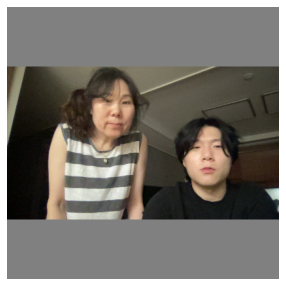

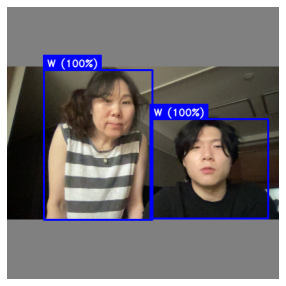

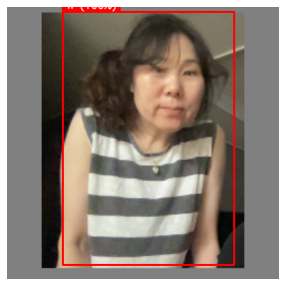

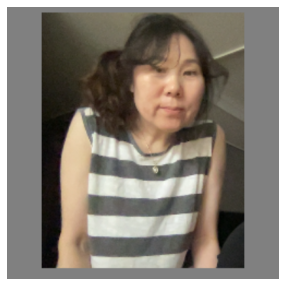

In [358]:
ser = serial.Serial('/dev/cu.usbmodem1101', 9600)
traffic_sign(ser, '2')
try:
    send_time = time.time()
    cap = cv2.VideoCapture(0)
    #ser = serial.Serial('/dev/cu.usbmodem11101', 9600)

    if cap.isOpened():
        print('동영상을 잘 불러왔습니다.')
    while True:
        ret, frame = cap.read()

        if ret:
            #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            cv2.imshow('frame', frame)
            if cv2.waitKey(15) & 0xFF == ord('q'):
                break
            now = time.time()
            if int(now - send_time) > 4: # 5초마다 예측하는 건데 하는데 10초라
                send_time = now
                answers = pred(frame, ser)
                print(f'사람 수는 : {len(answers)}, 각 클래스 별 answer는 : {answers}') 
            #if문 돌아가는데 10초
    if cap.isOpened:
        cap.release()
    cv2.destroyAllWindows()
except:
    ser.close()

In [359]:
if cap.isOpened:
    cap.release()
cv2.destroyAllWindows()

In [229]:
ser 

Serial<id=0x2bd554100, open=False>(port='/dev/cu.usbmodem11101', baudrate=9600, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False)

In [223]:
ser.close()

In [226]:
reading_from_user('병규규규규규규규규귝우ㅜ우우우우우우우우우우우우우님, 북치기 박치기 북치기 박치기 북치기 박치기 북치기 박치기 북치기 박치기 북치기 박치기 북치기 박치기 북치기 박치기 북치기 박치기 북치기 박치기 북치기 박치기 북치기 박치기 북치기 박치기 북치기 박치기 북치기 박치기 북치기 박치기', 1)

In [222]:
traffic_sign(ser, str(1))

PortNotOpenError: Attempting to use a port that is not open

In [ ]:

input_text = f'{score} 점 입니다!'
language = 'ko' #언어
slow_audio_speed = False #속도
filename = "output.mp3" #저장명
audio_created =gTTS(text=input_text, lang=language, slow=slow_audio_speed) #오디오 생성
audio_created.save(filename) #오디오 저장
playsound.playsound('./output.mp3')

In [ ]:
from gtts import gTTS
import playsound